<a href="https://colab.research.google.com/github/zombe962/TensorFlow_study/blob/main/tensorflow_autodiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow 학습 - 자동 미분(Automatic differentiation)

2022.02.28

https://www.tensorflow.org/guide/autodiff

자동 미분 및 그래디언트(Automatic Differentiation and Gradients)

[자동 미분](https://en.wikipedia.org/wiki/Automatic_differentiation)은 신경망 학습을 위한 [역전파](https://en.wikipedia.org/wiki/Backpropagation)와 같은 머신러닝 알고리즘을 구현하는 데 유용하다.

이 가이드에서는 특히 즉시 실행(eager execution)에서 TensorFlow로 그래디언트를 계산하는 방법을 알아본다.

# 설정(Setup)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

# 그래디언트 계산하기(Computing gradients)

자동으로 미분하기 위해 TensorFlow는 *정방향 패스* 동안 어떤 연산이 어떤 순서로 발생하는지 기억한다. 그런 다음 *역방향 패스* 동안 TensorFlow는 이 연산 목록을 역순으로 이동하여 그래디언트를 계산한다.

# 그래디언트 테이프(Gradient tapes)

텐서플로는 자동 미분(주어진 입력 변수에 대한 연산의 그래디언트(gradient)를 계산하는 것을 위한 tf.GradientTape API를 제공한다. tf.GradientTape는 컨텍스트(context) 안에서 실행된 모든 연산을 테이프(tape)에 '기록'한다. 그 다음 텐서플로는 [후진 방식 자동 미분(reverse mode differentiation)](https://en.wikipedia.org/wiki/Automatic_differentiation)을 사용해 테이프에 '기록된' 연산의 그래디언트를 계산한다.

예를 들면:

In [3]:
x = tf.Variable(3.0)

with tf.GradientTape() as tape:
  y = x**2

일부 연산을 기록한 후에는 GradientTape.gradient(target, sources)를 사용하여 일부 소스(종종 모델 변수)에 상대적인 일부 대상(종종 손실)의 그래디언트를 계산한다.

In [6]:
# dy = 2x * dx
dy_dx = tape.gradient(y, x)
dy_dx.numpy()

6.0

위의 예제는 스칼라를 사용하지만, tf.GradientTape는 모든 텐서에서 쉽게 작동한다.

In [12]:
w = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape:
  y = x @ w + b
  loss = tf.reduce_mean(y**2)
print(loss)

tf.Tensor(2.822177, shape=(), dtype=float32)
tf.Tensor(2.822177, shape=(), dtype=float32)


두 변수 모두에 대해 loss의 그래디언트를 가져오려면, 두 변수를 gradient 메서드에 소스로 전달할 수 있다. 테이프는 소스가 전달되는 방식에 대해 융통성이 있으며 목록 또는 사전의 중첩된 조합을 허용하고 같은 방식으로 구조화된 그래디언트를 반환한다.

In [9]:
[dl_dw, dl_db] = tape.gradient(loss, [w, b])

In [13]:
print(w.shape)
print(dl_dw.shape)
print(dl_dw)

(3, 2)
(3, 2)
tf.Tensor(
[[  4.7993526  -5.5710645]
 [  9.598705  -11.142129 ]
 [ 14.398058  -16.713194 ]], shape=(3, 2), dtype=float32)


다음은 그래디언트 계산이다. 이번에는 변수의 dictionary 를 전달한다.

In [11]:
my_vars = {
    'w':w,
    'b':b
}

grad = tape.gradient(loss, my_vars)
grad['b']

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 4.7993526, -5.5710645], dtype=float32)>

# 모델에 대한 그래디언트(Gradients with respect to a model)

검사점 설정 및 내보내기를 위해 tf.Variables를 tf.Module 또는 해당 서브 클래스(layers.Layer 와 keras.Model) 중 하나로 수집하는 것이 일반적이다.

대부분의 경우 모델의 훈련 가능한 변수에 대한 그래디언트를 계산하려고 한다. tf.Module 의 모든 서브 클래스는 Module.trainable_variables 속성에서 변수를 집계하므로 몇 줄의 코드로 이러한 그래디언트를 계산할 수 있다.

In [14]:
layer = tf.keras.layers.Dense(2, activation='relu')
x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
  # Forward pass
  y = layer(x)
  loss = tf.reduce_mean(y**2)

# Calculate gradients with respect to every trainable variable
grad = tape.gradient(loss, layer.trainable_variables)

In [15]:
for var, g in zip(layer.trainable_variables, grad):
  print(f'{var.name}, shape: {g.shape}')

dense/kernel:0, shape: (3, 2)
dense/bias:0, shape: (2,)


# 테이프의 감시 대상 제어하기(Controlling what the tape watches)

기본 동작은 훈련 가능한 tf.Variable 에 액세스한 후 모든 연산을 기록하는 것이다. 그 이유는 다음과 같다.


*   테이프는 역방향 패스의 그래디언트를 계산하기 위해 정방향 패스에 기록할 연산을 알아야 한다.
*   테이프는 중간 출력에 대한 참조를 보우하므로 불필요한 연산을 기록하지 않는다.
*   가장 일반적인 사용 사례는 모든 모델의 훈련 가능한 변수에 대해 손실의 그래디언트를 계산하는 것이다.


예를 들어, 다음은 tf.Tensor 가 기본적으로 '감시'되지 않고 tf.Variable 을 훈련할 수 없기 때문에 그래디언트를 계산하지 못한다.



In [ ]:
# A trainable variable
x0 = tf.Variable(3.0, name='x0')
# Not trainable
x1 = tf.Variable(3.0, name='x1', trainable=False)
# Not a Variable: A variable + tensor returns a tensor.
x2 = tf.Variable(2.0, name='x2') + 1.0
# Not a variable
x3 = tf.constant(3.0, name='x3')

with tf.GradientTape() as tape:
  y = (x0**2) + (x1**2) + (x2**2)

grad = tape.gradient(y, [x0, x1, x2, x3])

for g in grad:
  print(g)

tf.GradientTape 는 사용자가 감시 대상 또는 감시 예외 대상을 제어할 수 있는 후크를 제공한다.

tf.Tensor 에 대한 그래디언트를 기록하려면 기록하려면 GradientTape.watch(x) 를 호출해야 한다.

In [16]:
x = tf.constant(3.0)
with tf.GradientTape() as tape:
  tape.watch(x)
  y = x**2

# dy = 2x * dx
dy_dx = tape.gradient(y, x)
print(dy_dx.numpy())

6.0


반대로, 모든 tf.Variables 을 감시하는 기본 동작을 비활성화하려면, 그래디언트 테이프를 만들 때 watch_accessed_variables=False 를 설정한다. 이 계산은 두 가지 변수를 사용하지만, 변수 중 하나의 그래디언트만 연결한다.

In [18]:
x0 = tf.Variable(0.0)
x1 = tf.Variable(10.0)

with tf.GradientTape(watch_accessed_variables=False) as tape:
  tape.watch(x1)
  y0 = tf.math.sin(x0)
  y1 = tf.nn.softplus(x1)
  y = y0 + y1
  ys = tf.reduce_sum(y)

x0 에서 GradientTape.watch 가 호출되지 않았으므로 이에 대한 그래디언트가 계산되지 않는다.

In [19]:
# dys/dx1 = exp(x1) / (1+exp(x1)) = sigmoid(x1)
grad = tape.gradient(ys, {'x0': x0, 'x1':x1})

print('dy/dx0:', grad['x0'])
print('dy/dx1:', grad['x1'].numpy())

dy/dx0: None
dy/dx1: 0.9999546


# 중간 결과(Intermediate results)

tf.GradientTape 컨텍스트 내에서 계산된 중간값과 관련하여 출력의 그래디언트를 요청할 수도 있다.

In [20]:
x = tf.constant(3.0)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = x*x
  z = y*y

# Use the tape to compute the gradient of z with respect to the intermediate value y.
# dz_dy = 2 * y and y = x ** 2 = 9
print(tape.gradient(z, y).numpy())

18.0


기본적으로, GradientTape.gradient 메서드가 호출되면 GradientTape 가 보유한 리소스가 해제된다. 도일한 계산에 대해 여러 그래디언트가 계산하려면 persistent=True 그래디언트 테이프를 만든다. 이렇게 하면 테이프 객체가 가비지 수집될 때 리소스가 해제되면 gradient 메서드를 여러 번 호출할 수 있다. 예를 들면 다음과 같다.

In [21]:
x = tf.constant([1, 3.0])
with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  y = x * x
  z = y * y

print(tape.gradient(z, x).numpy()) # 108,0 (4 * x**3 at x = 3)
print(tape.gradient(y, x).numpy()) # 6.0 (2 * x)

[  4. 108.]
[2. 6.]


In [22]:
del tape  # Drop the reference to the tape

# 성능에 대한 참고 사항(Notes on performance)

*   그래디언트 테이프 컨텍스트 내에서 연산을 수행하는 것과 관련하여 작은 오버헤드가 있다. 대부분의 Eager 실행에는 상당한 비용이 들지 않지만, 필요한 경우에만 테이프 컨텍스트를 사용해야 한다.
*   그래디언트 테이프는 메모리를 사용하여 역방향 패스 동안 사용하기 위해 입력 및 출력을 포함한 중간 결과를 저장한다.

효율성을 위해(ReLU와 같은) 일부 연산은 중간 결과를 유지할 필요가 없으며 정방향 패스 동안에 정리된다. 그러나 테이프에서 persistent=True를 사용하면 *아무것도 삭제되지 않으며* 최대 메모리 사용량이 높아진다.

# 스칼라가 아닌 대상의 그래디언트(Gradients of non-scalar targets)

그래디언트는 기본적으로 스칼라에 대한 연산이다.

In [23]:
x = tf.Variable(2.0)
with tf.GradientTape(persistent=True) as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient(y0, x).numpy())
print(tape.gradient(y1, x).numpy())

4.0
-0.25


따라서, 여러 대상의 그래디언트를 요청하면 각 소스의 결과는 다음과 같다.

*   대상의 합계 또는 그에 상응하는 그래디언트
*   각 대상의 그래디트의 합계

In [24]:
x = tf.Variable(2.0)
with tf.GradientTape() as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient({'y0': y0, 'y1' : y1}, x).numpy()) # (2x at x=2) + (-(1/x)^2 at x=2)

3.75


마찬가지로, 대상이 스칼라가 아닌 경우 합계의 그래디언트가 계산된다.

In [25]:
x = tf.Variable(2.)

with tf.GradientTape() as tape:
  y = x * [3., 4.]

print(tape.gradient(y, x).numpy())

7.0


이렇게 하면, 손실 컬렉션 합계의 그래디언트 또는 요소별 손실 계산 합계의 그래디언트를 간단하게 구할 수 있습니다.

각 항목에 대해 별도의 그래디언트가 필요한 경우, [야고비안](https://www.tensorflow.org/guide/advanced_autodiff?authuser=1#jacobians)을 참조하세요.

어떤 경우에는 야고비안을 건너뛸 수 있습니다. 요소별 계산의 경우, 각 요소가 독립적이므로 합의 그래디언트는 입력 요소와 관련하여 각 요소의 미분을 제공합니다.

In [26]:
x = tf.linspace(-10.0, 10.0, 200+1)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = tf.nn.sigmoid(x)

dy_dx = tape.gradient(y, x)

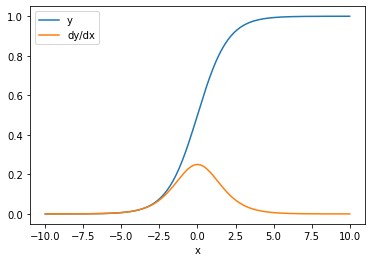

In [27]:
plt.plot(x, y, label='y')
plt.plot(x, dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')

# 흐름 제어하기(Control flow)

그래디언트 테이프는 실행되는 연산을 기록하기 때문에 Python 제어 흐름이 자연스럽게 처리됩니다(예: if 및 while 구문).

여기서는 if의 각 분기에 서로 다른 변수가 사용됩니다. 그래디언트는 사용된 변수에만 연결됩니다.

In [28]:
x = tf.constant(1.0)

v0 = tf.Variable(2.0)
v1 = tf.Variable(2.0)

with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  if x > 0.0:
    result = v0
  else:
    result = v1**2 

dv0, dv1 = tape.gradient(result, [v0, v1])

print(dv0)
print(dv1)

tf.Tensor(1.0, shape=(), dtype=float32)
None


제어문 자체는 미분할 수 없으므로 그래디언트 기반 최적화 프로그램에는 보이지 않습니다.

위 예제에서 x 값에 따라 테이프는 result = v0 또는 result = v1**2를 기록합니다. x에 대한 그래디언트는 항상 None입니다.

In [29]:
dx = tape.gradient(result, x)

print(dx)

None


# None의 그래디언트 구하기

대상이 소스에 연결되어 있지 않으면 그래디언트는 None 이다.

In [30]:
x = tf.Variable(2.)
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  z = y * y
print(tape.gradient(z, x))

None


여기서 z는 명확하게 x에 연결되어 있지 않지만, 그래디언트의 연결을 끊을 수 있는 몇 가지 덜 명확한 방법이 있다.

## 1. 변수를 텐서로 대체
"테이프의 감시 대상 제어" {/a0} 섹션에서 테이프가 자동으로 tf.Variable을 감시하지만 tf.Tensor는 감시하지 않는 것을 살펴보았다.

한 가지 일반적인 오류는 Variable.assign를 사용하여 tf.Variable를 업데이트하는 대신 실수로 tf.Variable을 tf.Tensor로 대체하는 것이다. 예를 들면, 다음과 같다.

In [ ]:
x = tf.Variable(2.0)

for epoch in range(2):
  with tf.GradientTape() as tape:
    y = x+1   # A variable + tensor returns a tensor.

  print(type(x).__name__, ":", tape.gradient(y, x))
  x = x + 1   # This should be 'x.assign_add(1)'

## 2. TensorFlow 외부에서 계산

계산에서 TensorFlow를 종료하면 테이프가 그래디언트 경로를 기록할 수 없다. 예를 들면, 다음과 같다.

In [31]:
x = tf.Variable([[1.0, 2.0],
                 [3.0, 4.0]], dtype=tf.float32)

with tf.GradientTape() as tape:
  x2 = x**2

  # This step is calculated with NumPy
  y = np.mean(x2, axis=0)

  # Like most ops, reduce_mean will cast the NumPy array to a constant tensor
  # using `tf.convert_to_tensor`.
  y = tf.reduce_mean(y, axis=0)

print(tape.gradient(y, x))

None


## 3. 정수 또는 문자열을 통해 그래디언트를 구함.

정수와 문자열은 구별할 수 없다. 계산 경로에서 이러한 데이터 유형을 사용하면 그래디언트는 없다.

아무도 문자열을 미분할 것으로 기대하지 않지만, dtype을 지정하지 않으면 실수로 int 상수 또는 변수를 만들기 쉽다. 

In [32]:
x = tf.constant(10)

with tf.GradientTape() as g:
  g.watch(x)
  y = x * x

print(g.gradient(y, x))

None


TensorFlow는 유형 간에 자동으로 전송되지 않으므로 실제로 그래디언트가 누락되는 대신 type error가 발생한다. 

## 4. 상태(state) 저장 개체를 통해 그래디언트를 구함.

상태(state)가 그래디언트를 중지한다.상태 저장 객체에서 읽을 때 테이프는 현재 상태만 볼 수 있으며 현재 상태에 이르게 된 기록은 볼 수 없다.

tf.Tensor 는 변경할 수 없다. 텐서가 작성된 후에는 변경할 수 없다. *값*은 있지만 상태는 없다. 지금까지 논의된 모든 연산은 상태 비저장이다. tf.matmul의 출력은 입력에만 의존한다. 

tf.Variable은 내부 상태와 값을 갖는다. 변수를 사용하면 상태를 읽는다. 변수와 관련하여 그래디언트를 계산하는 것이 일반적이지만, 변수의 상태는 그래디언트 계산이 더 멀리 돌아가지 않도록 차단한다. 예를 들면, 다음과 같다.

In [33]:
x0 = tf.Variable(3.0)
x1 = tf.Variable(0.0)

with tf.GradientTape() as tape:
  # Update x1 = x1 + x0.
  x1.assign_add(x0)
  # The tape starts recording from x1.
  y = x1**2   # y = (x1 + x0)**2

# This doesn't work.
print(tape.gradient(y, x0))   #dy/dx0 = 2*(x1 + x0)

None


마찬가지로, tf.data.Dataset 반복기(iterator)와 tf.queue는 상태 저장이며 이들을 통과하는 텐서의 모든 그래디언트를 중지합니다.

# 그래디언트가 등록되지 않음(No gradient registered)

일부 tf.Operation 는 **미분 불가능한 것으로 등록되어** None을 반환한다. 다른 연산에는 **그래디언트가 등록되지 않았다.**

tf.raw_ops 페이지에는 그래디언트가 등록된 저수준 op가 표시된다.

그래디언트가 등록되지 않은 float op를 통해 그래디언트를 얻고자 시도하면 테이프가 자동으로 None을 반환하는 대신 오류가 발생한다. 이렇게 하면 무언가 잘못되었다는 것을 알 수  있다. 

예를 들어, tf.image.adjust_contrast 함수는 그래디언트를 가질 수 있지만 그래디언트는 구현되지 않은 raw_ops.AdjustContrastv2 를 래핑한다.


In [34]:
image = tf.Variable([[[0.5, 0.0, 0.0]]])
delta = tf.Variable(0.1)

with tf.GradientTape() as tape:
  new_image = tf.image.adjust_contrast(image, delta)

try:
  print(tape.gradient(new_image, [image, delta]))
  assert False   # This should not happen.
except LookupError as e:
  print(f'{type(e).__name__}: {e}')

LookupError: gradient registry has no entry for: AdjustContrastv2


이 op를 통해 미분해야 하는 경우, 그래디언트를 구현하고 등록하거나(tf.RegisterGradient 사용) 다른 ops를 사용하여 함수를 다시 구현해야 한다.

# None 대신 0(Zeros instead of None)

연결되지 않은 그래디언트의 경우 None 대신 0을 가져오는 것이 편리한 경우가 있다. 연결되지 않은 그래디언트가 있을 때 unconnected_gradients 인수를 사용하여 반환할 항목을 결정할 수 있다.

In [35]:
x = tf.Variable([2., 2.])
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  z = y**2
print(tape.gradient(z, x, unconnected_gradients=tf.UnconnectedGradients.ZERO))

tf.Tensor([0. 0.], shape=(2,), dtype=float32)
